In [1]:
import xarray as xr
import pandas as pd
import numpy as np

from math import atan2

import matplotlib.pyplot as plt
import seaborn as sns

## Read AR xarray and generate xarray with daily number of AR instances/landfalls for different domains

In [2]:
!mkdir Figs # create folder for storing all plots

mkdir: cannot create directory ‘Figs’: File exists


In [3]:
# dataset provided by Deanna
ds = '/glade/work/dlnash/asp2021/USWest_Water/data/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(ds)

In [4]:
# function provided by Deanna
def calculate_AR_frequency_landfall(lat1, lat2, lon1, lon2):
    
    # Auxiliary for domain name
    lonmin_suf = 'W' if lon1<0 else 'E'
    lonmax_suf = 'W' if lon2<0 else 'E'
    latmin_suf = 'S' if lat1<0 else 'N'
    latmax_suf = 'S' if lat2<0 else 'N'
    lons_inputs = f'{np.abs(lon1)}{lonmin_suf}-{np.abs(lon2)}{lonmax_suf}'
    lats_inputs = f'{np.abs(lat1)}{latmin_suf}-{np.abs(lat2)}{latmax_suf}'
    
    # longitudes from 0-360, and lat1/lon1 should be smaller than lat2/lon2
    if lon1<0: lon1 = 360+lon1
    if lon2<0: lon2 = 360+lon2
    lon1, lon2 = sorted([lon1, lon2])
    lat1, lat2 = sorted([lat1, lat2])
    
    # Calculate the fraction of gridcells bounded by subregion that has AR present
    subset_da = ds.kidmap.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    subset_sum = subset_da.count(dim=('lat', 'lon'))
    area = subset_da.lat.size*subset_da.lon.size

    R01_frac = subset_sum/area
    R01_id = subset_da.max(dim=('lat', 'lon')) # get the event id
    ds_new = xr.Dataset({'R01': (['time'], R01_frac.squeeze().values)}, coords={'time': R01_frac.time.values})
    df = ds_new.to_dataframe()
    df['ar'] = 0
    idx = (df['R01'] > 0)
    df.loc[idx, 'ar'] = 1
    daily_ct = df.ar.resample('D').sum()
    daily_ct = pd.DataFrame(daily_ct)

    # subset ds for landfall location
    da = ds.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    da = da.lfloc.squeeze()

    subset_sum = da.count(dim=('lat', 'lon')) # count number of AR landfalls withing the domain of interest
    df = subset_sum.to_dataframe()
    df = df.drop(columns=['lev', 'ens'])

    daily_ct_lf = df.lfloc.resample('D').sum()
    daily_ct_lf = pd.DataFrame(daily_ct_lf)
    
    data = pd.merge(daily_ct, daily_ct_lf, left_index=True, right_index=True)
    data = xr.DataArray(data).rename({'dim_1': 'Variable'})
    data = data.assign_coords({'Domain': f'{lons_inputs}_{lats_inputs}'})
    
    return data

In [5]:
bnds = [[-140, -110, 10, 55], [-140, -110, 41, 52.5], [-140, -110, 32.5, 41]] # Full Domain, North, & South parts
AR_Results = []
for i_bnds in bnds:
    lonmin, lonmax, latmin, latmax = i_bnds
    AR_Results.append(calculate_AR_frequency_landfall(latmin, latmax, lonmin, lonmax))

AR_Results = xr.concat(AR_Results, dim='Domain')

del(bnds, i_bnds, lonmin, lonmax, latmin, latmax, ds, calculate_AR_frequency_landfall)

## MJO data

In [6]:
# read daily MJO data from BOM; data available at http://www.bom.gov.au/climate/mjo/#tabs=MJO-phase
MJO_BOM = '/glade/work/nikolaosm/ASP2021/USWest_Water/notebooks/rmm.74toRealtime.txt'
MJO_BOM = pd.read_csv(MJO_BOM, delimiter="\s+", skiprows=[0])

# process data for keeping and modifying columns of interest 
MJO_BOM = MJO_BOM.iloc[:, :7] # keep columns of interest
MJO_BOM.columns = ['Year', 'Month', 'Day', 'RMM1', 'RMM2', 'Phase', 'Amplitude'] # rename columns
MJO_BOM.index = pd.to_datetime(MJO_BOM[['Year', 'Month', 'Day']]) # create datetime index
Months = ['Jan', 'Feb', 'Mar', 'Arp', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
MJO_BOM.Month = MJO_BOM.Month.map({i:j for i, j in enumerate(Months, 1)}) # rename month column to string format

# change missing value flags with NaN (Missing Value= 1.E36 or 999)
MJO_BOM[MJO_BOM==999] = np.nan
MJO_BOM.loc[MJO_BOM.RMM1>=1e+35, 'RMM1'] = np.nan
MJO_BOM.loc[MJO_BOM.RMM2>=1e+35, 'RMM2'] = np.nan
MJO_BOM.loc[MJO_BOM.Amplitude>=1e+35, 'Amplitude'] = np.nan

# generate additional columns of interest
angles = MJO_BOM.apply(lambda row: atan2(row['RMM2'], row['RMM1']), axis=1)
angles = (2*np.pi + angles) * (angles < 0) + angles*(angles > 0)
angles = np.rad2deg(angles)
MJO_BOM['Angle'] = angles
MJO_BOM['Phase2'] = (MJO_BOM['Phase']*(MJO_BOM['Amplitude']>1)).replace({0:np.nan}) # phase of active MJO only
bins_used = [0,1,1.5,2.5,5] # categorical data for MJO (not active, level1, level2, Level3 according to amplitude)
MJO_BOM['Level'], Bins = pd.cut(MJO_BOM.Amplitude, bins=bins_used, labels=['L0', 'L1', 'L2', 'L3'], retbins=True)

# keep final dataframe with specified order of columns
MJO_BOM = MJO_BOM[['RMM1', 'RMM2', 'Amplitude', 'Phase', 'Phase2', 'Angle', 'Level', 'Year', 'Month', 'Day']]
del(angles, bins_used)

In [7]:
# subset data of interest for MJO plot
dates_used = pd.date_range('20161101', '20170331')
MJO = MJO_BOM.loc[dates_used]
MJO.index = range(len(MJO))

# make a "trick" for introducing one more day at the end of each month with same data as last day of the month but 
# tags as the first day of the next month, so that the plot lines can be continuous
# Please share a better way if you aware of :) This one is too complex for no reason i guess :P
change = (MJO['Month'].shift() != MJO['Month']) # find indices where the month changes
change = np.where(change.iloc[1:]==True)[0] # keep row indices of the 1rst day of each month (besides first month)
additions = MJO.loc[change+1].copy(deep=True) # keep the rows with the first day of each month
# change the MJO info of the first day of each month with the last day of the previous month
cols_used = ['RMM1', 'RMM2', 'Amplitude', 'Phase']
additions.loc[:, cols_used] = MJO.loc[change][cols_used].values
additions.index = additions.index - .5 # change the index to -.5 so when sorting this row goes in correct location

MJO = pd.concat([MJO, additions]).sort_index() # concat MJO data and addtions and sort indices
del(change, additions, cols_used)

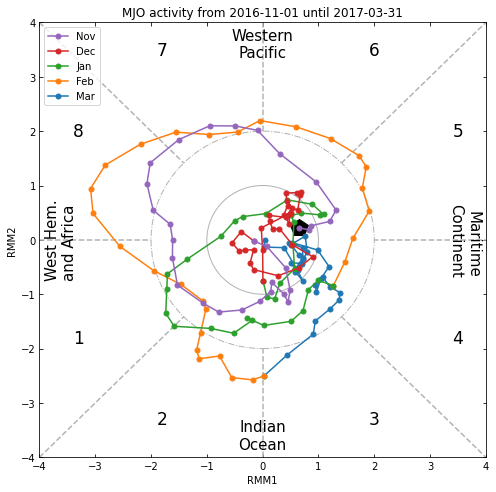

In [8]:
# MJO plot
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.set_xlim(-4, 4)
ax.set_xlabel('RMM1')
ax.set_ylim(-4, 4)
ax.set_ylabel('RMM2')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', direction='in')
ax.axvline(0, linestyle='--', color='0.7')
ax.axhline(0, linestyle='--', color='0.7')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='0.7')
ax.plot([0, 1], [1, 0], transform=ax.transAxes, linestyle='--', color='0.7')
ax.add_patch(plt.Circle((0,0),2, zorder=10, linestyle='-.', facecolor='white', edgecolor='.7'))
ax.add_patch(plt.Circle((0,0),1, zorder=10, facecolor='white', edgecolor='.7'))
plt.text(0, -3.9, 'Indian\nOcean', ha='center', va='bottom', size=15)
plt.text(0, 3.9, 'Western\nPacific', ha='center', va='top', size=15)
plt.text(-3.9, 0, 'West Hem.\nand Africa', ha='left', va='center', size=15, rotation=90)
plt.text(3.9, 0, 'Maritime\nContinent', ha='right', va='center', size=15, rotation=270)
plt.text(-3.4, -1.9, '1', size=17)
plt.text(-1.9, -3.4, '2', size=17)
plt.text(1.9, -3.4, '3', size=17)
plt.text(3.4, -1.9, '4', size=17)
plt.text(3.4, 1.9, '5', size=17)
plt.text(1.9, 3.4, '6', size=17)
plt.text(-1.9, 3.4, '7', size=17)
plt.text(-3.4, 1.9, '8', size=17)

for i_month in MJO.Month.unique()[::-1]: # reverse order so the "double point" is colored with the previous month
    grp = MJO.query('Month==@i_month')
    plt.plot(grp.RMM1, grp.RMM2,'o-', label = i_month, zorder=20, markersize=5)

plt.plot(MJO.RMM1.iloc[0], MJO.RMM2.iloc[0],'p', zorder=10, markersize=18, color='black')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
ax.set_title(f"MJO activity from {dates_used[0].strftime('%Y-%m-%d')} until {dates_used[-1].strftime('%Y-%m-%d')}")

plt.show()
fig.savefig('Figs/MJO_Evolution.png', dpi=300)
del(dates_used, fig, ax, i_month, grp, handles, labels)

## ENSO data

In [9]:
ENSO = 'https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data'
ENSO = pd.read_csv(ENSO, delimiter="\s+", skiprows=[0], header=None, index_col=0)
ENSO = ENSO.iloc[:152] # actual data up to row #152
ENSO.columns = Months
ENSO.index.name = 'Year'
ENSO[ENSO==-99.99] = np.nan
ENSO = ENSO.stack().reset_index()
ENSO.columns = ['Year', 'Month', 'ENSO']
ENSO['Day'] = 1
ENSO.Month = ENSO.Month.map({j:i for i, j in enumerate(Months, 1)})
ENSO.index = pd.to_datetime(ENSO[['Year', 'Month', 'Day']])
ENSO = ENSO[['ENSO']]
ENSO.ENSO = ENSO.ENSO.astype(float)
ENSO = ENSO.resample('M').sum() # for having index at end of each month
ENSO.columns = ['Nino 3.4']

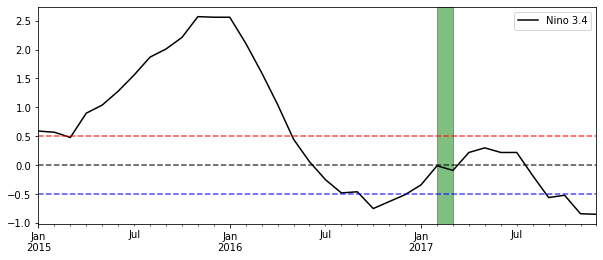

In [10]:
# ENSO plot
fig, ax  = plt.subplots(1,1, figsize=(10, 4))
ENSO.loc[pd.date_range('2015-01-01', '2018-01-01', freq='M')].plot(ax=ax, color='black')
ax.axhline(0, color='black', linestyle='--', alpha=.7)
ax.axhline(0.5, color='r', linestyle='--', alpha=.7)
ax.axhline(-0.5, color='b', linestyle='--', alpha=.7)
ax.axvspan(pd.to_datetime('2017-02-01'), pd.to_datetime('2017-03-01'), alpha=0.5, color='green')
plt.show()
fig.savefig('Figs/ENSO.png', dpi=300)
del(fig, ax)

## QBO data

In [11]:
QBO = '/glade/work/nikolaosm/ASP2021/USWest_Water/notebooks/QBO.txt'
QBO = pd.read_csv(QBO, delimiter="\s+", header=None, index_col=0)
QBO.columns = ['QBO']
QBO['Year'] = (QBO.index//1).astype(int)
QBO['Month'] = np.round((QBO.index%1)*12).astype(int)+1
QBO['Day'] = 1
QBO.index = pd.to_datetime(QBO[['Year', 'Month', 'Day']])
QBO = QBO.resample('M').mean()[['QBO']].dropna()
# create QBO normalized anomalies (anomalies from monthly climatology & normalized per month)
QBO['QBO_A'] = (QBO - QBO.groupby(QBO.index.month).transform('mean'))/QBO.groupby(QBO.index.month).transform('std')
# 3-month moving average normalized anomalies
QBO['QBO_AnomMoving'] = QBO.QBO_A.rolling(3, center=True, min_periods=1).mean()

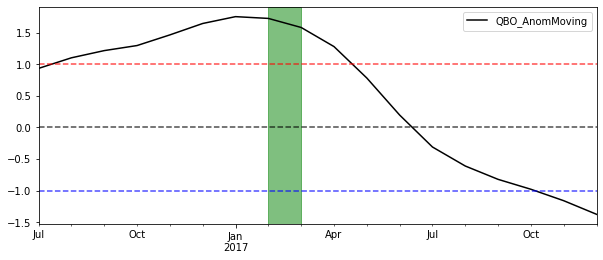

In [12]:
# QBO plot
fig, ax = plt.subplots(1,1,figsize=(10, 4))
QBO.loc[pd.date_range('2016-07-01', '2018-01-01', freq='M')][['QBO_AnomMoving']].plot(ax=ax, color='black')
ax.axvspan(pd.to_datetime('2017-02-01'), pd.to_datetime('2017-03-01'), alpha=0.5, color='green')
ax.axhline(1, color='r', linestyle='--', alpha=.7)
ax.axhline(-1, color='b', linestyle='--', alpha=.7)
ax.axhline(0, color='black', linestyle='--', alpha=.7)
plt.show()
fig.savefig('Figs/QBO_Anom.png', dpi=300)
del(fig, ax)

## Climatological Connections between ARs and MJO, QBO

In [13]:
# create daily QBO data from monthly timeseries (each day of the month same QBO value)
QBO_daily = QBO.resample('D').mean().backfill()
All_data = pd.merge(MJO_BOM, QBO_daily, left_index=True, right_index=True) # merge MJO and QBO data
All_data.head()

,RMM1,RMM2,Amplitude,Phase,Phase2,Angle,Level,Year,Month,Day,QBO,QBO_A,QBO_AnomMoving
1974-06-01,1.63447,1.20304,2.02948,5.0,5.0,36.354662,L2,1974,Jun,1,-13.86,-0.769081,-0.779098
1974-06-02,1.60289,1.01512,1.89729,5.0,5.0,32.346329,L2,1974,Jun,2,-13.86,-0.769081,-0.779098
1974-06-03,1.51625,1.08551,1.86476,5.0,5.0,35.599541,L2,1974,Jun,3,-13.86,-0.769081,-0.779098
1974-06-04,1.50981,1.03573,1.83092,5.0,5.0,34.450131,L2,1974,Jun,4,-13.86,-0.769081,-0.779098
1974-06-05,1.55906,1.30518,2.03326,5.0,5.0,39.934665,L2,1974,Jun,5,-13.86,-0.769081,-0.779098


### Rolling daily anomalies of AR activity, similar to https://www.nature.com/articles/s41612-017-0008-2#Sec4

In [14]:
AR_used = AR_Results.groupby('time.dayofyear') - AR_Results.groupby('time.dayofyear').mean() # anomalies
# AR_used = AR_used.groupby('time.dayofyear')/AR_actual.groupby('time.dayofyear').std() # for standarizing values

AR_used = AR_used.rolling(time=5, min_periods=1).sum()

In [15]:
# get % deviation from climatological monthly frequencies
FreqAR = AR_Results.resample(time='M').sum()
FreqAR_Anom = FreqAR.groupby('time.month')-FreqAR.groupby('time.month').mean()
FreqAR_Anom = FreqAR_Anom.groupby('time.month')/FreqAR.groupby('time.month').mean()*100
np.round(FreqAR_Anom.sel(time='2017-02-28')).to_dataset('Variable').to_dataframe() # check deviations for Feb2017

,ar,lfloc,time,month
Domain,,,,
140W-110W_10N-55N,6.0,58.0,2017-02-28,2
140W-110W_41N-52.5N,8.0,-10.0,2017-02-28,2
140W-110W_32.5N-41N,49.0,175.0,2017-02-28,2


In [16]:
# keep common dates between AR frequencies and ESNO timeseries
common_dates = set(FreqAR_Anom.time.values) & set(ENSO.index.values)
common_dates = pd.Index(list(common_dates))
# common_dates = common_dates[common_dates.month.isin([11, 12, 1, 2, 3])]

ENSO_used = ENSO.loc[common_dates]
FreqAR_Anom_used = FreqAR_Anom.sel(time=common_dates)

months_after_ENSO = range(0, 13) # statistics for composites between ENSO (also lagged) and AR frequencies

In [17]:
FreqAR_Anom_used.isel(time=range(5)).mean('time')

<xarray.DataArray (Domain: 3, Variable: 2)>
array([[ -9.18714253, -23.16857083],
       [-21.00735348,  -5.56531499],
       [-28.7186494 , -36.74440971]])
Coordinates:
  * Variable  (Variable) object 'ar' 'lfloc'
  * Domain    (Domain) object '140W-110W_10N-55N' ... '140W-110W_32.5N-41N'

In [18]:
def Analysis_ENSO(enso_used):
    if enso_used == 'Pos':
        dates_used = ENSO_used.query('`Nino 3.4`>.5').index
    elif enso_used == 'Neg':
        dates_used = ENSO_used.query('`Nino 3.4`<-.5').index
    elif enso_used == 'Neutral':
        dates_used = ENSO_used.query('`Nino 3.4`>=-.5 and `Nino 3.4`<=.5').index

    Res = np.zeros((len(months_after_ENSO), len(FreqAR_Anom_used.Domain), 7, 2))*np.nan # lead, Dom, Stats, Var
    for i_loc, i in enumerate(months_after_ENSO):
        dates_selected = dates_used+pd.DateOffset(months=i)
        dates_selected = dates_selected[dates_selected.isin(ENSO_used.index)]
        data_used = FreqAR_Anom_used.sel(time=dates_selected)
        Res[i_loc, :, 0, :] = data_used.mean('time').values # mean 
        Res[i_loc, :, 1, :] = data_used.std('time').values # std
        Res[i_loc, :, 2, :] = data_used.quantile(q=.5, dim='time').values # median
        Res[i_loc, :, 3, :] = Res[i_loc, :, 0, :]/Res[i_loc, :, 1, :] # Signal 2 Noise
        Res[i_loc, :, 4, :] = (data_used>0).sum('time')/len(dates_selected)*100 # Positives %
        Res[i_loc, :, 5, :] = (data_used<0).sum('time')/len(dates_selected)*100 # Negatives %
        Res[i_loc, :, 6, :] = len(dates_used)
        
    return Res

In [19]:
CompositesENSO = np.zeros((3, len(months_after_ENSO), len(AR_used.Domain), 7, 2))*np.nan # ENSO, ld, D., Stat, Var 
for i_loc, i_enso in enumerate(['Pos', 'Neg', 'Neutral']):
    CompositesENSO[i_loc, :, ...] = Analysis_ENSO(i_enso)
        
CompositesENSO = xr.DataArray(CompositesENSO, dims=['ENSO', 'Lead', 'Domain', 'Statistics', 'Variable'],
                              coords={'ENSO': np.array([1, -1, 0]), 'Lead': months_after_ENSO, 
                                      'Domain': AR_used.Domain.values, 'Variable': ['ar', 'lfloc'],
                                      'Statistics': ['mean', 'std', 'median', 'S2N', 'Pos', 'Neg', 'counts']})
CompositesENSO = CompositesENSO.sortby('ENSO')
del(i_loc, i_enso)

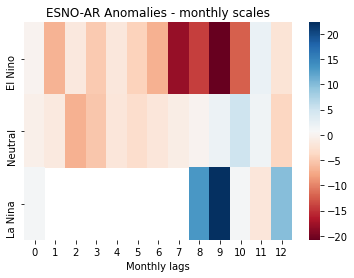

In [20]:
# ENSO-AR plot
prc = 55 # minimum % of either positive/negative for masking the results (should be over 50% for working)
Composites_mask = (CompositesENSO.sel(Statistics='Pos')>prc) | (CompositesENSO.sel(Statistics='Neg')>prc)
Composites_plot = CompositesENSO.where(Composites_mask)
Composites_plot = Composites_plot.isel(Domain=2)
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.heatmap(Composites_plot.sel(Statistics='mean', Variable='lfloc'), cmap='RdBu', ax=ax)
ax.set_yticklabels(['El Nino', 'Neutral', 'La Nina'])
ax.set_title('ESNO-AR Anomalies - monthly scales')
ax.set_xlabel('Monthly lags')
fig.savefig('Figs/ESNO_AR.png', dpi=300)
del(prc, Composites_mask, fig, ax)

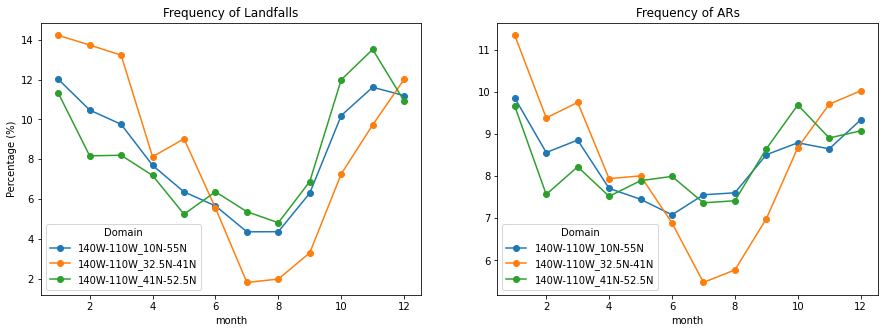

In [21]:
# plot the AR and landfalls climatological frequencies (check which months are of interest)
FreqAR = AR_Results.resample(time='M').sum()
FreqAR = FreqAR.groupby('time.month').mean().to_dataset('Variable')
FreqAR = FreqAR/FreqAR.sum('month')*100 
FreqAR = FreqAR.to_dataframe().reset_index()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
FreqAR.pivot_table(columns='month', index='Domain', values='lfloc').T.plot(style='o-', ax=ax[0])
ax[0].set_title('Frequency of Landfalls')
FreqAR.pivot_table(columns='month', index='Domain', values='ar').T.plot(style='o-', ax=ax[1])
ax[1].set_title('Frequency of ARs')
ax[0].set_ylabel('Percentage (%)')
plt.show()
fig.savefig('Figs/AR_Freqs.png', dpi=300)
del(FreqAR, fig, ax)

In [22]:
# common dates between AR and MJO/QBO data
common_dates = set(AR_used.time.values) & set(All_data.index.values)
common_dates = pd.Index(list(common_dates))
common_dates = common_dates[common_dates.month.isin([11, 12, 1, 2, 3])] # keep only Nov-March where most ARs occur

All_data = All_data.loc[common_dates]
AR_used = AR_used.sel(time=common_dates)

In [23]:
days_after_MJO = range(50) # up to how many days after MJO are we interested for composite statistics with AR?

In [24]:
def Analysis(qbo_used, mjo_used):
    if qbo_used == 'East':
        dates_used = All_data.query('Phase2==@mjo_used and QBO_AnomMoving<0').index
    elif qbo_used == 'West':
        dates_used = All_data.query('Phase2==@mjo_used and QBO_AnomMoving>0').index
    elif qbo_used == 'Neutral':
        dates_used = All_data.query('Phase2==@mjo_used and QBO_AnomMoving>-.5 and QBO_AnomMoving<.5').index
    elif qbo_used == 'All':
        dates_used = All_data.query('Phase2==@mjo_used').index

    Res = np.zeros((len(days_after_MJO), len(AR_used.Domain), 7, 2))*np.nan # lead-time, Domain, Stats, ar/lfloc
    for i_loc, i in enumerate(days_after_MJO):
        dates_selected = dates_used+np.timedelta64(i, 'D')
        dates_selected = dates_selected[dates_selected.isin(All_data.index)]
        data_used = AR_used.sel(time=dates_selected)
        Res[i_loc, :, 0, :] = data_used.mean('time').values # mean 
        Res[i_loc, :, 1, :] = data_used.std('time').values # std
        Res[i_loc, :, 2, :] = data_used.quantile(q=.5, dim='time').values # median
        Res[i_loc, :, 3, :] = Res[i_loc, :, 0, :]/Res[i_loc, :, 1, :] # Signal 2 Noise
        Res[i_loc, :, 4, :] = (data_used>0).sum('time')/len(dates_selected)*100 # Positives %
        Res[i_loc, :, 5, :] = (data_used<0).sum('time')/len(dates_selected)*100 # Negatives %
        Res[i_loc, :, 6, :] = len(dates_used)
        
    return Res

In [25]:
Composites = np.zeros((8, len(days_after_MJO), 4, len(AR_used.Domain), 7, 2))*np.nan # MJO, ld, QBO, D., Stat, Var 
for i_loc, i_mjo in enumerate(range(1, 9)):
    for j_loc, i_qbo in enumerate(['East', 'West', 'Neutral', 'All']):
        Composites[i_loc, :, j_loc, ...] = Analysis(i_qbo, i_mjo)
        
Composites = xr.DataArray(Composites, dims=['MJO', 'Lead', 'QBO', 'Domain', 'Statistics', 'Variable'],
                          coords={'MJO': range(1, 9), 'Lead': days_after_MJO, 'Domain': AR_used.Domain.values,
                                  'QBO': ['East', 'West', 'Neutral', 'All'], 'Variable': ['ar', 'lfloc'],
                                  'Statistics': ['mean', 'std', 'median', 'S2N', 'Pos', 'Neg', 'counts']})

del(i_loc, i_mjo, j_loc, i_qbo)

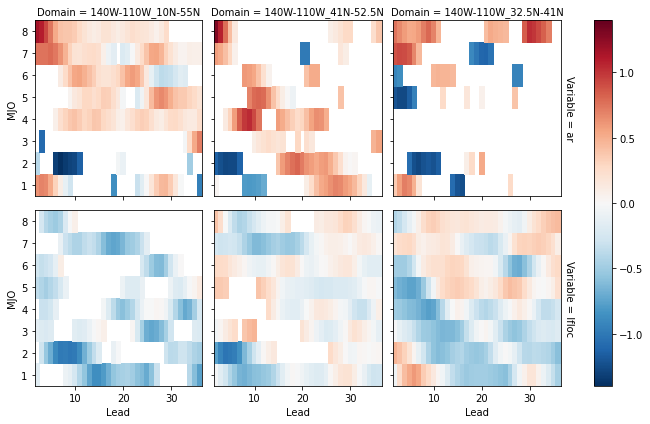

In [26]:
prc = 55
Composites_plot = Composites.where((Composites.sel(Statistics='Pos')>prc) | (Composites.sel(Statistics='Neg')>prc))
Composites_plot.sel(Statistics='mean', Lead=range(2, 37), QBO='All').plot(col='Domain', row='Variable')

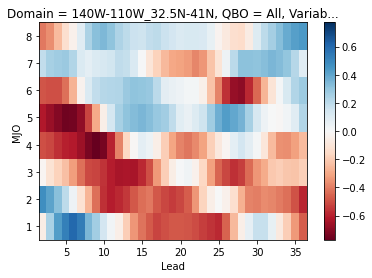

In [27]:
Com_plot = Composites.isel(Domain=2, QBO=3) # connections between MJO phase and California AR (no QBO included)
Com_plot.sel(Statistics='mean', Lead=range(2, 37), Variable='lfloc').plot(cmap='RdBu')
plt.savefig('Figs/MJO_only.png', dpi=300)

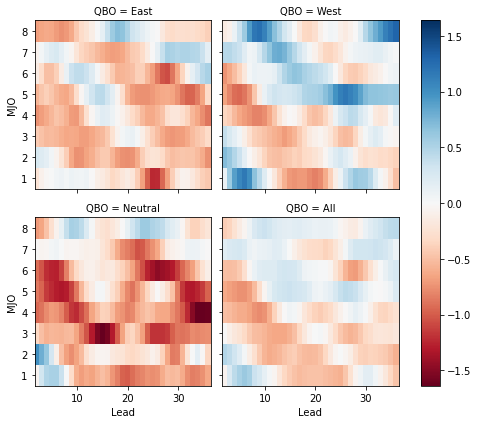

In [28]:
Com_plot = Composites.isel(Domain=2) # 2nd domain is southwest US coast (California)
Com_plot.sel(Statistics='mean', Lead=range(2, 37), Variable='lfloc').plot(col='QBO', col_wrap=2, cmap='RdBu')
plt.savefig('Figs/MJO_QBO_California.png', dpi=300)

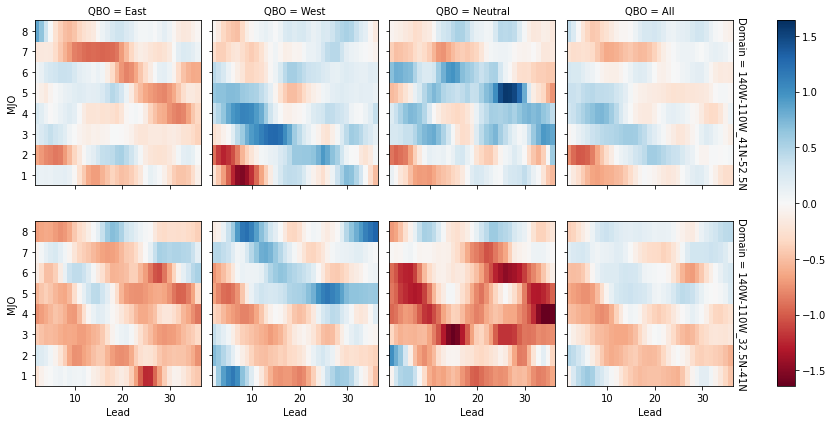

In [29]:
Com_plot = Composites.isel(Domain=range(1, 3))
Com_plot.sel(Statistics='mean', Lead=range(2, 37), Variable='lfloc').plot(col='QBO', row='Domain', cmap='RdBu')
plt.savefig('Figs/MJO_QBO.png', dpi=300)